# Evaluate model performance

Kendra Wyant  
June 8, 2025

## Set Up Environment

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "32a0bc8ced92c79756b56ddcdc9a06e639795da6"

In [ ]:

suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(tidymodels))
suppressPackageStartupMessages(library(tidyposterior))
library(kableExtra, exclude = "group_rows")
library(Rcpp, exclude = "populate")
library(brms, exclude = c("ar", "mixture"))


Loading 'brms' package (version 2.22.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').

In [ ]:

devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true")


ℹ SHA-1 hash of file is "de12d764438078a9341db9bc0b2472c87e0ae846"

ℹ SHA-1 hash of file is "6112ad4934c18197bb71037f5d65b97e1fd2b039"

In [ ]:
path_models_lag <- format_path(str_c("studydata/risk/models/lag"))
path_processed <- format_path(str_c("studydata/risk/data_processed/lag"))
path_shared <- format_path(str_c("studydata/risk/data_processed/shared"))


## Read in Data

In [ ]:
auroc_0 <- read_csv(here::here(path_models_lag, 
                                   "test_auroc_6_x_5_1day_0_v3_nested_strat_lh.csv"),
                      col_types = cols()) 

auroc_336 <- read_csv(here::here(path_models_lag, 
                                   "test_auroc_6_x_5_1day_336_v3_nested_strat_lh.csv"),
                      col_types = cols()) 


probs_0 <- read_rds(here::here(path_models_lag, "outer_preds_6_x_5_1day_0_v3_nested_strat_lh.rds"))
probs_336 <- read_rds(here::here(path_models_lag, "outer_preds_6_x_5_1day_336_v3_nested_strat_lh.rds"))

auroc_0_dem <- read_csv(here::here(path_models_lag, 
                                   "test_auroc_6_x_5_1day_0_v3_nested_strat_lh_fairness.csv"),
                      col_types = cols()) 
auroc_336_dem <- read_csv(here::here(path_models_lag, 
                                   "test_auroc_6_x_5_1day_336_v3_nested_strat_lh_fairness.csv"),
                      col_types = cols()) 

feat <- read_csv(here::here(path_processed, str_c("features_0lag_v3.csv")),
                 col_types = cols()) |> 
  select(label_num, subid, dttm_label, lapse, demo_age, demo_sex, demo_income, demo_race) |> 
  arrange(label_num) 

feat_336 <- read_csv(here::here(path_processed, str_c("features_336lag_v3.csv")),
                 col_types = cols()) |> 
  select(label_num, subid, dttm_label, lapse, demo_age, demo_sex, demo_income, demo_race) |> 
  arrange(label_num) 

pp_tidy_dem <- read_csv(here::here(path_models_lag, "posteriors_dem.csv"), 
                        show_col_types = FALSE) |> 
  mutate(lag = factor(lag, levels = c(0, 336),
                      labels = c("No lag", "2 weeks")),
         model = factor(model)) |> 
  mutate(group = case_when(model %in% c("female", "male") ~ "Sex (female, male)",
                           model %in% c("not white", "non-hispanic white") ~ "Race (not White, White)",
                           model %in% c("below poverty", "above poverty") ~ "Income (below poverty, above poverty)")) |> 
  filter(!is.na(lag))

ci_dem <- read_csv(here::here(path_models_lag, "pp_dem_all.csv"), 
                   show_col_types = FALSE) |> 
  mutate(lag = factor(lag, levels = c(0, 336),
                      labels = c("No lag", "2 weeks")),
         model = factor(model)) |> 
  mutate(group = case_when(model %in% c("female", "male") ~ "Sex (female, male)",
                           model %in% c("not white", "non-hispanic white") ~ "Race (not White, White)",
                           model %in% c("below poverty", "above poverty") ~ "Income (below poverty, above poverty)")) |> 
  filter(!is.na(lag))

lapses <- auroc_0 <- read_csv(here::here(path_shared, 
                                   "lapses.csv"),
                      col_types = cols()) 

contrasts <- read_csv(here::here(path_models_lag, "pp_dem_contrast_all.csv"), 
                   show_col_types = FALSE) |> 
  mutate(lag = factor(lag, levels = c(0, 336),
                      labels = c("No lag", "2 weeks")))


## No Lag Model

### Overall performance

In [ ]:
median(auroc_0$roc_auc)


NULL

### Probabilities

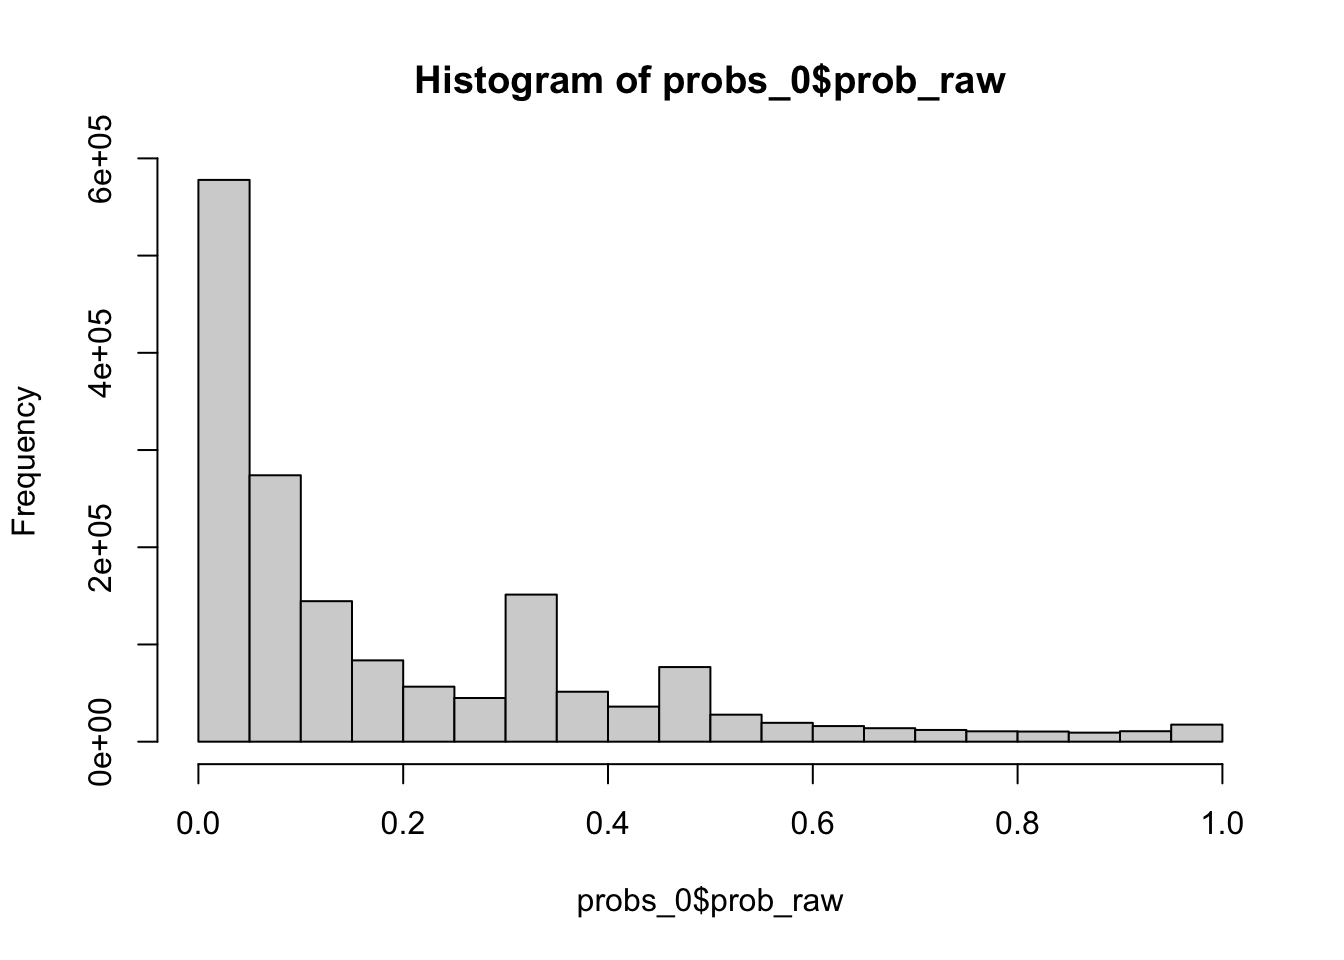

In [ ]:
hist(probs_0$prob_raw)


### Calibration

Using beta calibration without issues

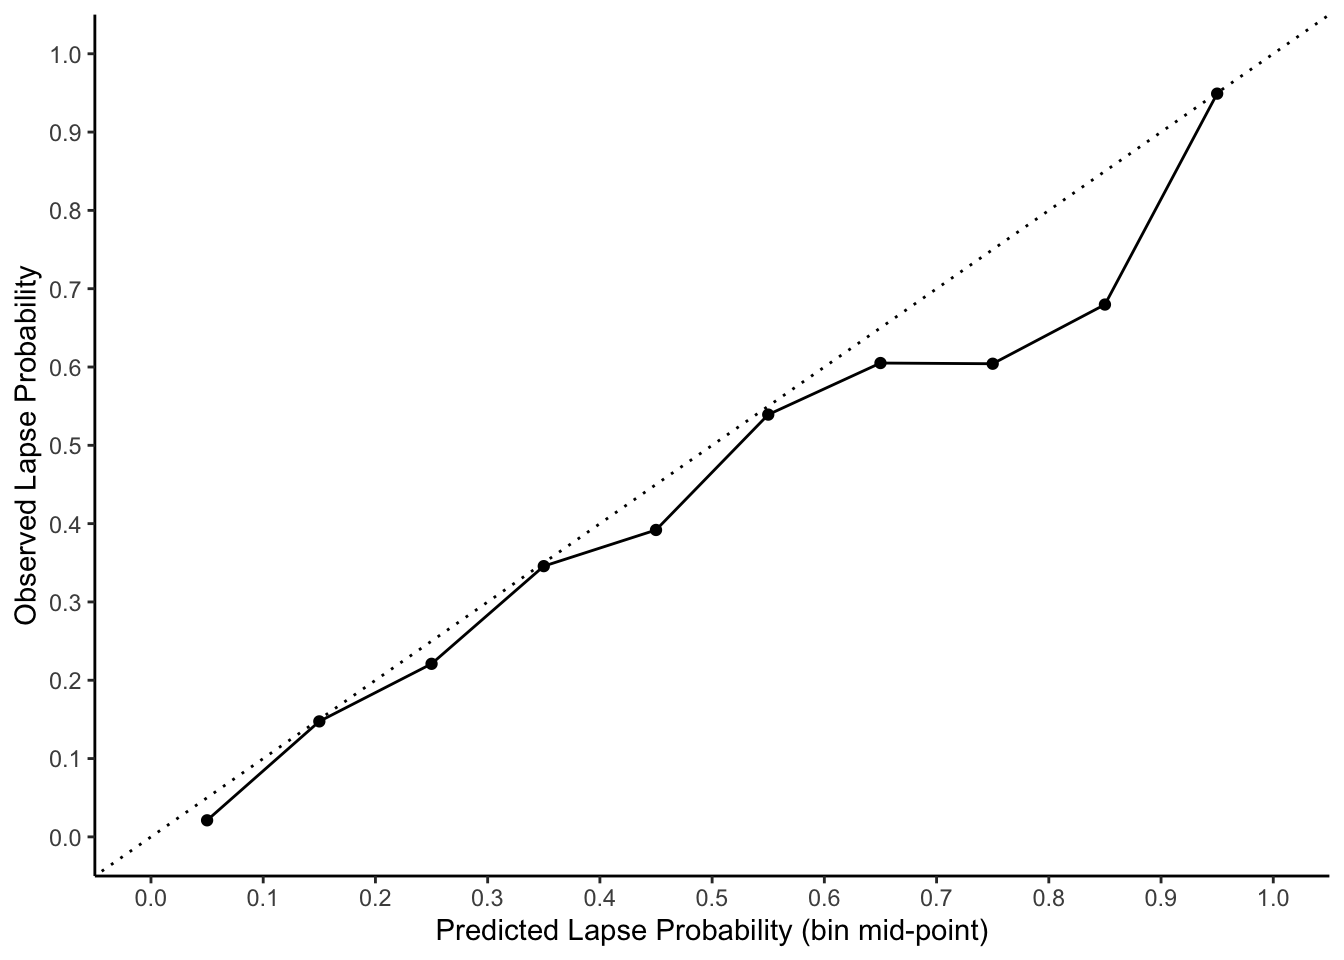

In [ ]:
bin_width = 0.10

probs_0 |> 
  mutate(bins = cut(prob_logi, breaks = seq(0, 1, bin_width)), 
         lapse = if_else(label == "Lapse", 1, 0)) |> 
  group_by(bins)  |> 
  summarize(mean_lapse = mean(lapse),
            .groups = "drop") |>
  mutate(bins = as.numeric(bins),
         midpoints = bin_width/2 + bin_width * (bins - 1))  |> 
  ggplot(data = _, aes(x = midpoints, y = mean_lapse)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dotted") +
  geom_line() +
  geom_point() +
  labs(x = "Predicted Lapse Probability (bin mid-point)",
       y = "Observed Lapse Probability") +
  scale_x_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) +
  scale_y_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) 


### Fairness

Only one fold missing

In [ ]:
naniar::miss_var_summary(auroc_0_dem)


# A tibble: 7 × 3
  variable        n_miss pct_miss
  <chr>            <int>    <num>
1 not white            1     3.33
2 outer_split_num      0     0   
3 female               0     0   
4 male                 0     0   
5 white                0     0   
6 above poverty        0     0   
7 below poverty        0     0   

median auroc for groups

In [ ]:
auroc_0_dem |> 
  summarise(across(c(female:`below poverty`), ~median(.x, na.rm = TRUE)))


# A tibble: 1 × 6
  female  male `not white` white `above poverty` `below poverty`
   <dbl> <dbl>       <dbl> <dbl>           <dbl>           <dbl>
1  0.893 0.928       0.832 0.914           0.910           0.901

Problem is a few folds in Not White condition are extra low

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`stat_bin()`).

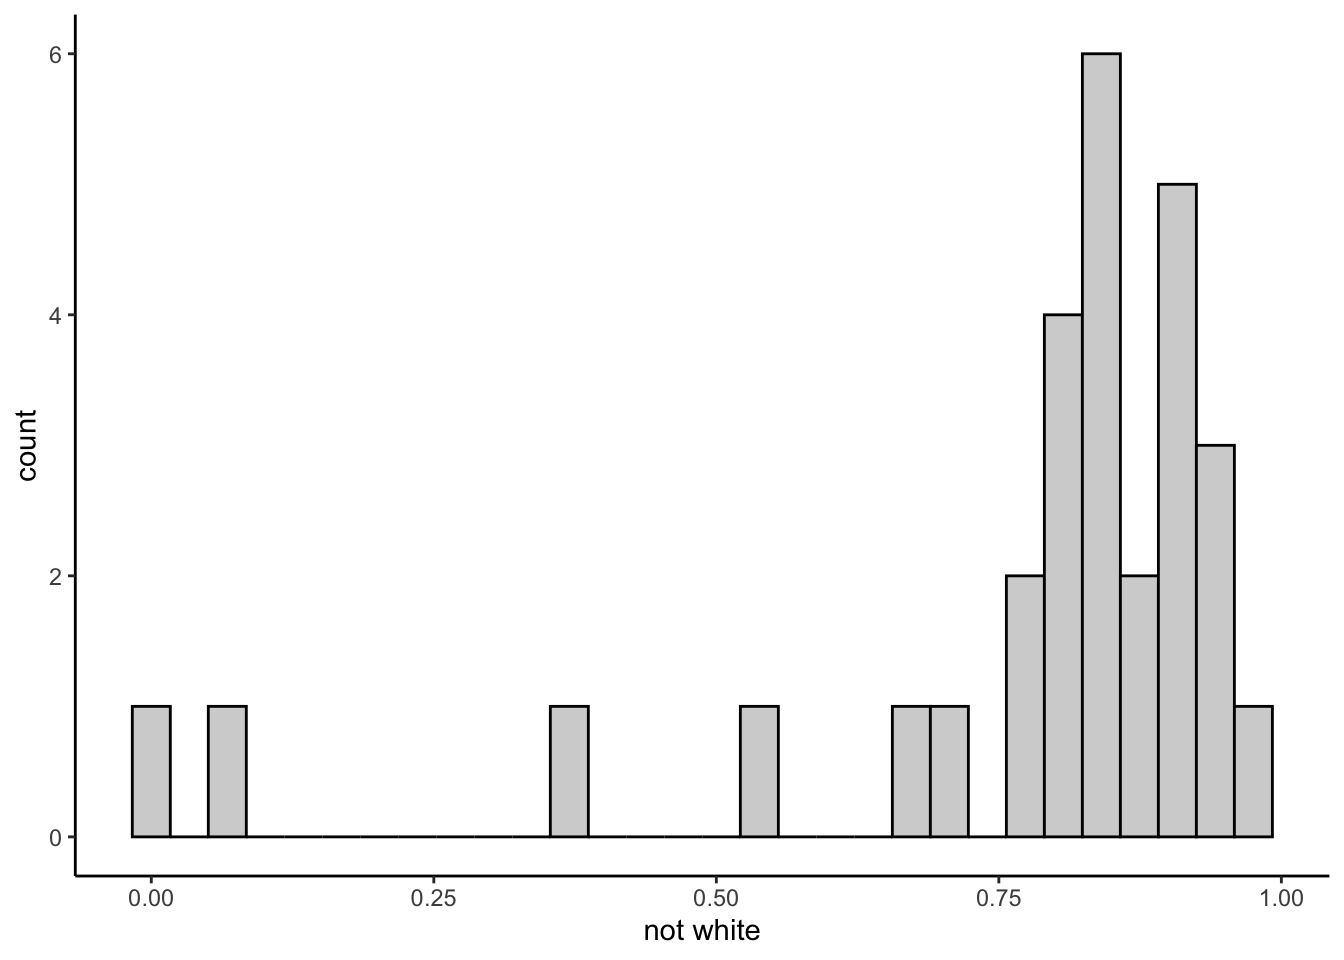

In [ ]:
auroc_0_dem |> 
  ggplot(aes(x = `not white`)) +
  geom_histogram(fill = "light grey", color = "black")


Look at breakdown of groups in splits with low auROC

In [ ]:
feat_preds <- feat |> 
  mutate(label = if_else(lapse == "yes", "Lapse", "No lapse"),
         id_obs = label_num) |>
  right_join(probs_0, by = c("id_obs", "label")) |> 
  select(-c(label_num, lapse)) |> 
  mutate(label = factor(label, levels = c("Lapse", "No lapse")))

feat_preds <- feat_preds |> 
  mutate(demo_sex = if_else(demo_sex == "Female", "female", "male"),
         demo_race = if_else(demo_race == "White/Caucasian", "white", "not white"),
         demo_income = if_else(demo_income < 15060, "below poverty", "above poverty"))


Splits below .1

In [ ]:
(outer_splits <- auroc_0_dem |> 
  filter(`not white` < .1) |> 
  pull(outer_split_num))


[1]  4 23

# A tibble: 4 × 3
  outer_split_num demo_race     n
            <int> <chr>     <int>
1               4 not white     2
2               4 white        28
3              23 not white     2
4              23 white        28

Check how many lapses from not white participants in each outer split

In [ ]:
(subids_4 <- feat_preds |> 
  filter(outer_split_num == 4 & demo_race == "not white") |> 
  pull(subid) |> 
  unique())


[1]  90 179

# A tibble: 1 × 14
  subid lapse_start_date lapse_start_time lapse_start         lapse_end_date
  <dbl> <chr>            <time>           <dttm>              <chr>         
1    90 07-27-2018       22:00            2018-07-28 03:00:00 07-28-2018    
# ℹ 9 more variables: lapse_end_time <time>, lapse_end <dttm>, duration <dbl>,
#   source <chr>, ema_1_6 <chr>, response_id <chr>, ema_end <dttm>,
#   exclude <lgl>, lapse_cnt <dbl>

[1] 119 190

# A tibble: 1 × 14
  subid lapse_start_date lapse_start_time lapse_start         lapse_end_date
  <dbl> <chr>            <time>           <dttm>              <chr>         
1   119 10-28-2018       03:00            2018-10-28 08:00:00 10-28-2018    
# ℹ 9 more variables: lapse_end_time <time>, lapse_end <dttm>, duration <dbl>,
#   source <chr>, ema_1_6 <chr>, response_id <chr>, ema_end <dttm>,
#   exclude <lgl>, lapse_cnt <dbl>

Bayseian

In [ ]:
ci_dem |> 
  filter(lag == "No lag")


# A tibble: 6 × 6
  model              pp_median pp_lower pp_upper lag    group                   
  <fct>                  <dbl>    <dbl>    <dbl> <fct>  <chr>                   
1 female                 0.890    0.862    0.911 No lag Sex (female, male)      
2 male                   0.933    0.916    0.946 No lag Sex (female, male)      
3 above poverty          0.909    0.870    0.936 No lag Income (below poverty, …
4 below poverty          0.897    0.854    0.928 No lag Income (below poverty, …
5 non-hispanic white     0.916    0.848    0.955 No lag Race (not White, White) 
6 not white              0.781    0.646    0.873 No lag Race (not White, White) 

# A tibble: 3 × 6
  contrast                        probability median    lower  upper lag   
  <chr>                                 <dbl>  <dbl>    <dbl>  <dbl> <fct> 
1 male vs female                        1     0.0430  0.0283  0.0594 No lag
2 above poverty vs below poverty        0.856 0.0123 -0.00708 0.0326 No lag
3 non-hispanic white vs not white       0.998 0.132   0.0590  0.224  No lag

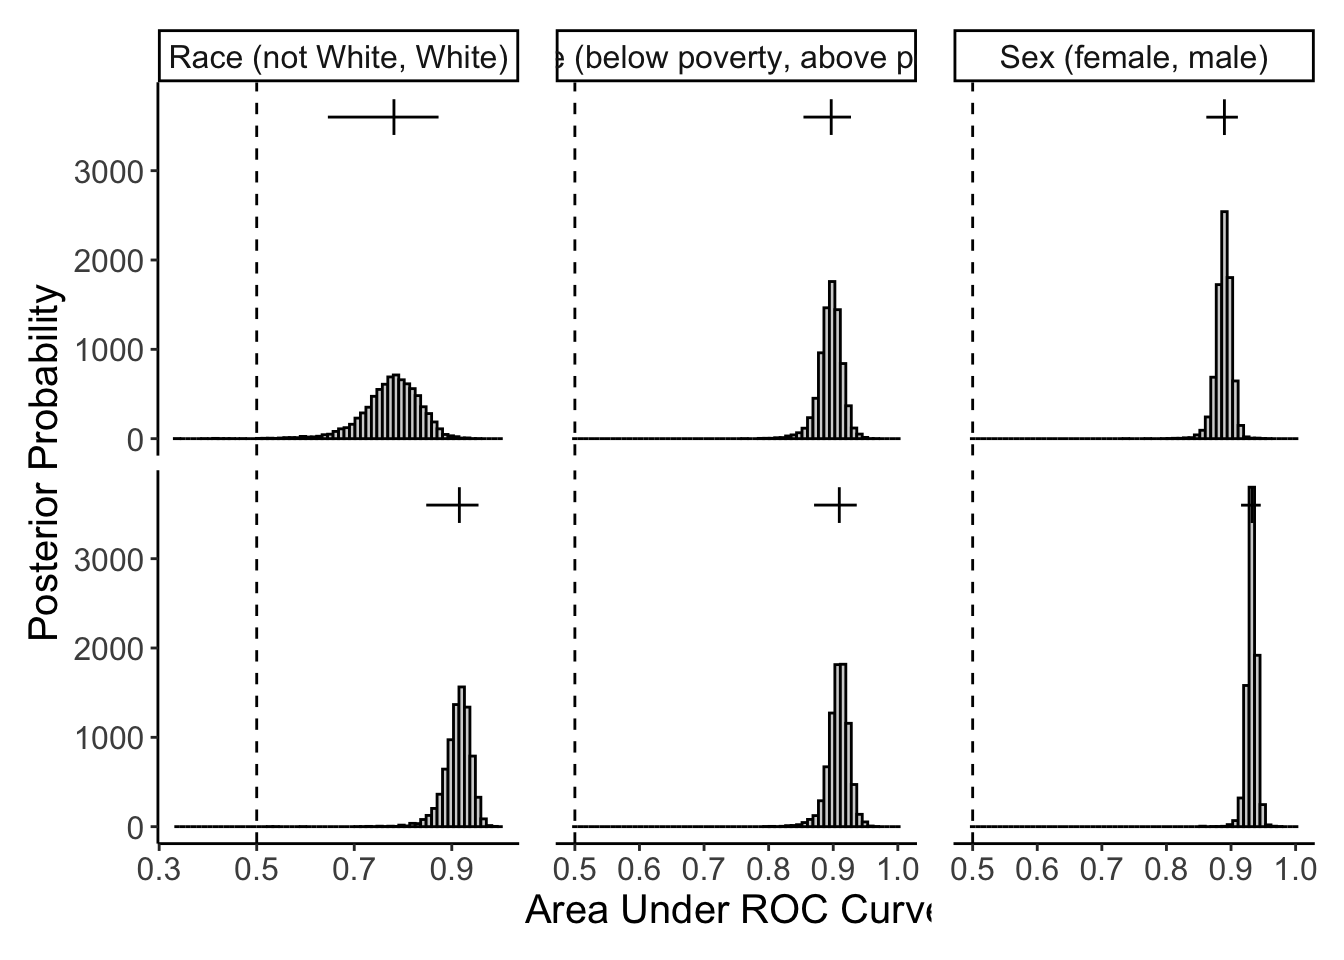

In [ ]:

race_no_lag <- pp_tidy_dem |>
  filter(lag == "No lag") |> 
  filter(str_detect(group, "Race")) |> 
  mutate(model = factor(model, levels = c("not white", "non-hispanic white"))) |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", linewidth = .5,  
                 bins = 60, fill = "light grey") +
  geom_segment(mapping = aes(y = 3400, yend = 3800, x = pp_median, xend = pp_median),
               linewidth = .5, color = "black", data = ci_dem |> filter(str_detect(group, "Race") & lag == "No lag") |> 
                 mutate(model = factor(model, levels = c("not white", "non-hispanic white"))) ) +
  geom_segment(mapping = aes(y = 3600, yend = 3600, x = pp_lower, xend = pp_upper),
               linewidth = .5, color = "black", data = ci_dem |> filter(str_detect(group, "Race") & lag == "No lag")  |> 
                 mutate(model = factor(model, levels = c("not white", "non-hispanic white"))) ) +
  facet_grid(model~group) +
  geom_vline(xintercept = .5, linewidth = .5, linetype = "dashed") +
  scale_y_continuous("Posterior Probability") +
  xlab(NULL) +
  expand_limits(x = c(.5, 1)) +
  theme_classic() +
  theme(legend.position = "none",
        text = element_text(size = 15),
        strip.text.y = element_blank())

income_no_lag <- pp_tidy_dem |>
  filter(lag == "No lag") |> 
  filter(str_detect(group, "Income")) |> 
  mutate(model = factor(model, levels = c("below poverty", "above poverty"))) |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", linewidth = .5,  
                 bins = 60, fill = "light grey") +
  geom_segment(mapping = aes(y = 3400, yend = 3800, x = pp_median, xend = pp_median),
               linewidth = .5, color = "black", data = ci_dem |> filter(str_detect(group, "Income") & lag == "No lag") |> 
                 mutate(model = factor(model, levels = c("below poverty", "above poverty"))) ) +
  geom_segment(mapping = aes(y = 3600, yend = 3600, x = pp_lower, xend = pp_upper),
               linewidth = .5, color = "black", data = ci_dem |> filter(str_detect(group, "Income") & lag == "No lag")  |> 
                 mutate(model = factor(model, levels = c("below poverty", "above poverty"))) ) +
  facet_grid(model~group) +
  geom_vline(xintercept = .5, linewidth = .5, linetype = "dashed") +
  scale_y_continuous(NULL) +
  xlab("Area Under ROC Curve") +
  expand_limits(x = c(.5, 1)) +
  theme_classic() +
  theme(legend.position = "none",
        text = element_text(size = 15),
        strip.text.y = element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.line.y = element_blank())

sex_no_lag <- pp_tidy_dem |>
  filter(lag == "No lag") |> 
  filter(str_detect(group, "Sex")) |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", linewidth = .5,  
                 bins = 60, fill = "light grey") +
  geom_segment(mapping = aes(y = 3400, yend = 3800, x = pp_median, xend = pp_median),
               linewidth = .5, color = "black", data = ci_dem |> filter(str_detect(group, "Sex") & lag == "No lag") ) +
  geom_segment(mapping = aes(y = 3600, yend = 3600, x = pp_lower, xend = pp_upper),
               linewidth = .5, color = "black", data = ci_dem |> filter(str_detect(group, "Sex") & lag == "No lag")  ) +
  facet_grid(model~group) +
  geom_vline(xintercept = .5, linewidth = .5, linetype = "dashed") +
  scale_y_continuous(NULL) +
  xlab(NULL) +
  expand_limits(x = c(.5, 1)) +
  theme_classic() +
  theme(legend.position = "none",
        text = element_text(size = 15),
        strip.text.y = element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.line.y = element_blank())

race_no_lag + income_no_lag + sex_no_lag


### Shaps

## 2-week lag Model

### Overall performance

In [ ]:
median(auroc_336$roc_auc)


[1] 0.8471884

### Probabilities

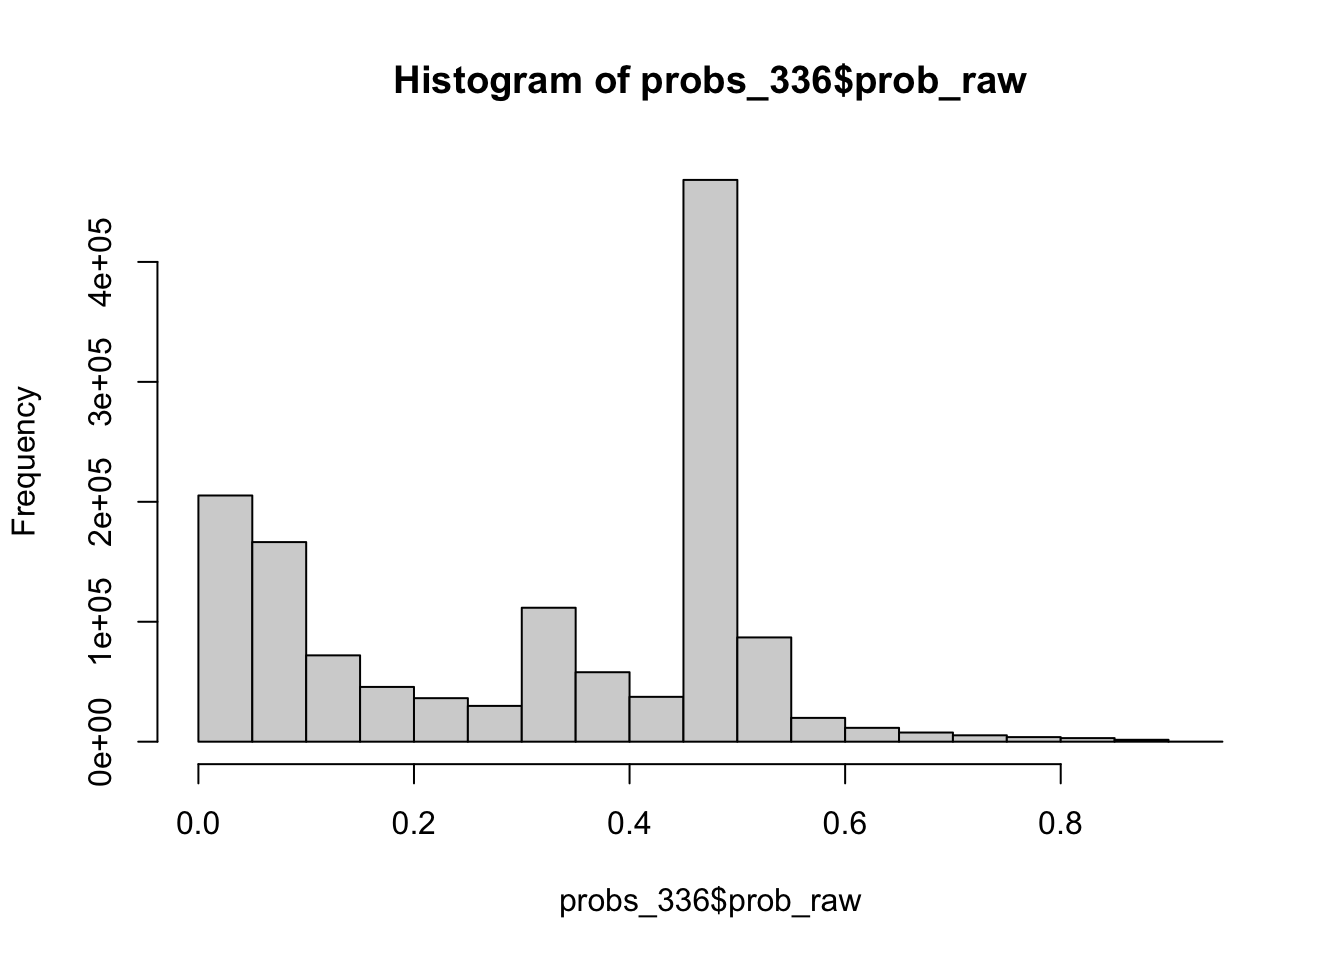

In [ ]:
hist(probs_336$prob_raw)


### Calibration

Using beta calibration without issues

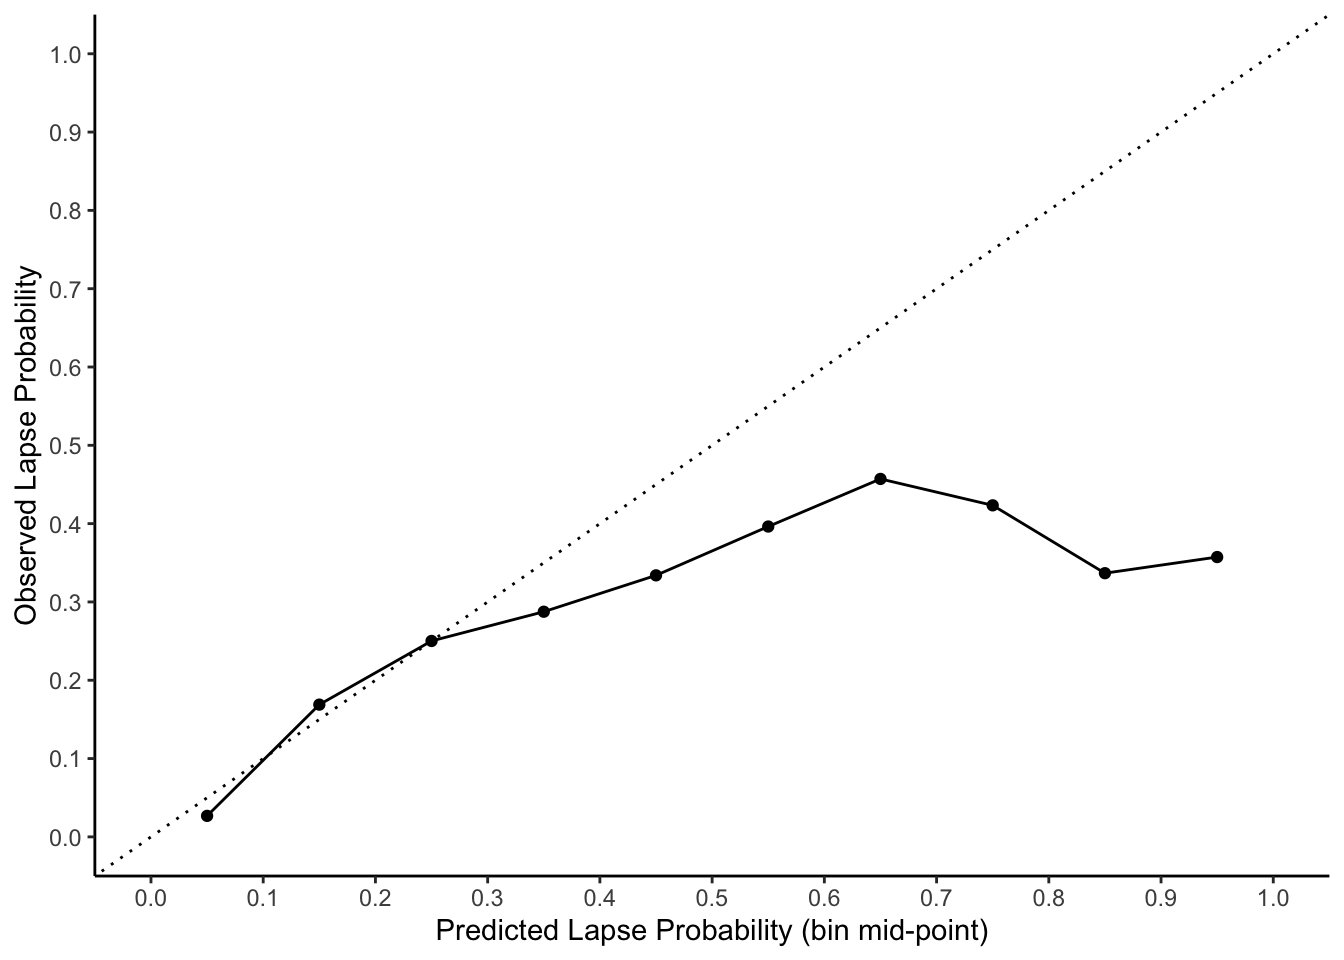

In [ ]:
bin_width = 0.10

probs_336 |> 
  mutate(bins = cut(prob_logi, breaks = seq(0, 1, bin_width)), 
         lapse = if_else(label == "Lapse", 1, 0)) |> 
  group_by(bins)  |> 
  summarize(mean_lapse = mean(lapse),
            .groups = "drop") |>
  mutate(bins = as.numeric(bins),
         midpoints = bin_width/2 + bin_width * (bins - 1))  |> 
  ggplot(data = _, aes(x = midpoints, y = mean_lapse)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dotted") +
  geom_line() +
  geom_point() +
  labs(x = "Predicted Lapse Probability (bin mid-point)",
       y = "Observed Lapse Probability") +
  scale_x_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) +
  scale_y_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) 


### Fairness

Only one fold missing

In [ ]:
naniar::miss_var_summary(auroc_336_dem)


# A tibble: 7 × 3
  variable        n_miss pct_miss
  <chr>            <int>    <num>
1 not white            3       10
2 outer_split_num      0        0
3 female               0        0
4 male                 0        0
5 white                0        0
6 above poverty        0        0
7 below poverty        0        0

median auroc for groups

In [ ]:
auroc_336_dem |> 
  summarise(across(c(female:`below poverty`), ~median(.x, na.rm = TRUE)))


# A tibble: 1 × 6
  female  male `not white` white `above poverty` `below poverty`
   <dbl> <dbl>       <dbl> <dbl>           <dbl>           <dbl>
1  0.783 0.892       0.804 0.848           0.854           0.803

Problem is a few folds in Not White condition are extra low

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`stat_bin()`).

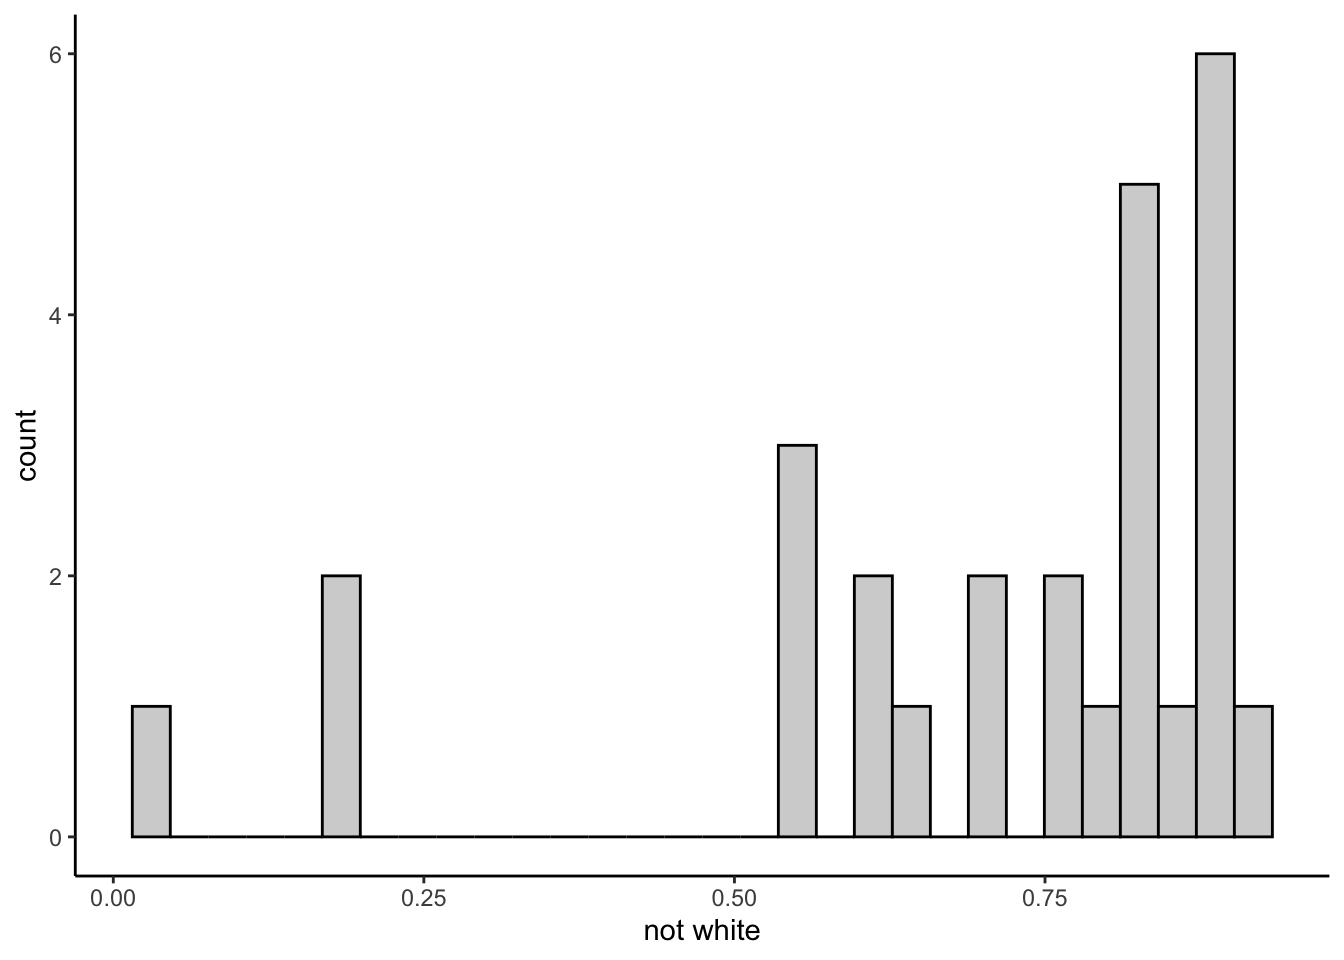

In [ ]:
auroc_336_dem |> 
  ggplot(aes(x = `not white`)) +
  geom_histogram(fill = "light grey", color = "black")


Bayseian

In [ ]:
ci_dem |> 
  filter(lag == "2 weeks")


# A tibble: 6 × 6
  model              pp_median pp_lower pp_upper lag     group                  
  <fct>                  <dbl>    <dbl>    <dbl> <fct>   <chr>                  
1 female                 0.796    0.748    0.834 2 weeks Sex (female, male)     
2 male                   0.895    0.865    0.916 2 weeks Sex (female, male)     
3 above poverty          0.851    0.797    0.892 2 weeks Income (below poverty,…
4 below poverty          0.811    0.750    0.861 2 weeks Income (below poverty,…
5 non-hispanic white     0.850    0.784    0.900 2 weeks Race (not White, White)
6 not white              0.719    0.621    0.801 2 weeks Race (not White, White)

# A tibble: 3 × 6
  contrast                        probability median   lower  upper lag    
  <chr>                                 <dbl>  <dbl>   <dbl>  <dbl> <fct>  
1 male vs female                        1     0.0979 0.0736  0.126  2 weeks
2 above poverty vs below poverty        0.980 0.0390 0.00782 0.0731 2 weeks
3 non-hispanic white vs not white       0.998 0.131  0.0598  0.209  2 weeks

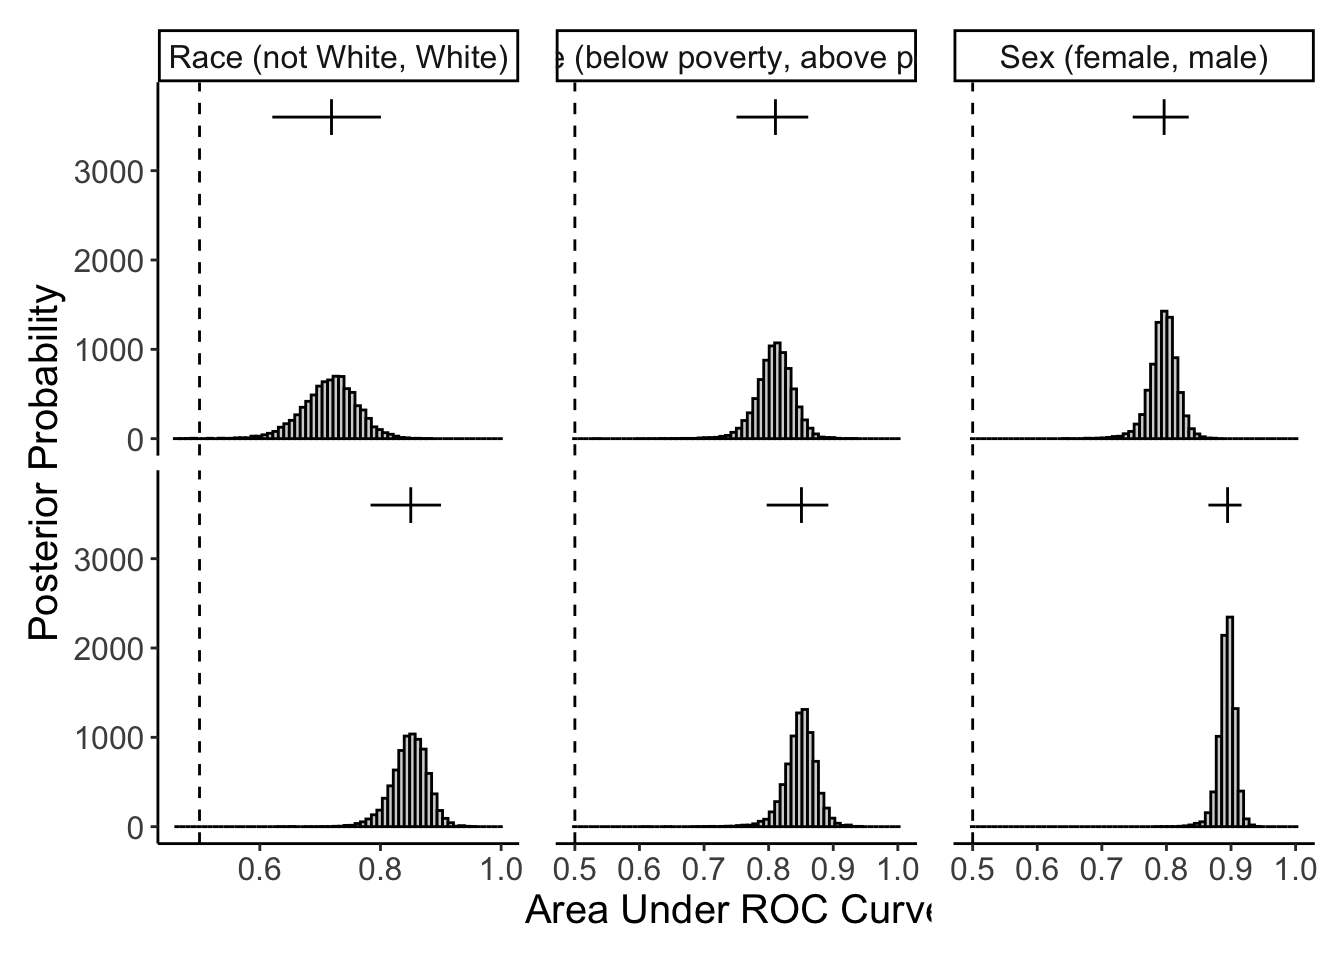

In [ ]:

race_lag <- pp_tidy_dem |>
  filter(lag == "2 weeks") |> 
  filter(str_detect(group, "Race")) |> 
  mutate(model = factor(model, levels = c("not white", "non-hispanic white"))) |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", linewidth = .5,  
                 bins = 60, fill = "light grey") +
  geom_segment(mapping = aes(y = 3400, yend = 3800, x = pp_median, xend = pp_median),
               linewidth = .5, color = "black", data = ci_dem |> filter(str_detect(group, "Race") & lag == "2 weeks") |> 
                 mutate(model = factor(model, levels = c("not white", "non-hispanic white"))) ) +
  geom_segment(mapping = aes(y = 3600, yend = 3600, x = pp_lower, xend = pp_upper),
               linewidth = .5, color = "black", data = ci_dem |> filter(str_detect(group, "Race") & lag == "2 weeks")  |> 
                 mutate(model = factor(model, levels = c("not white", "non-hispanic white"))) ) +
  facet_grid(model~group) +
  geom_vline(xintercept = .5, linewidth = .5, linetype = "dashed") +
  scale_y_continuous("Posterior Probability") +
  xlab(NULL) +
  expand_limits(x = c(.5, 1)) +
  theme_classic() +
  theme(legend.position = "none",
        text = element_text(size = 15),
        strip.text.y = element_blank())

income_lag <- pp_tidy_dem |>
  filter(lag == "2 weeks") |> 
  filter(str_detect(group, "Income")) |> 
  mutate(model = factor(model, levels = c("below poverty", "above poverty"))) |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", linewidth = .5,  
                 bins = 60, fill = "light grey") +
  geom_segment(mapping = aes(y = 3400, yend = 3800, x = pp_median, xend = pp_median),
               linewidth = .5, color = "black", data = ci_dem |> filter(str_detect(group, "Income") & lag == "2 weeks") |> 
                 mutate(model = factor(model, levels = c("below poverty", "above poverty"))) ) +
  geom_segment(mapping = aes(y = 3600, yend = 3600, x = pp_lower, xend = pp_upper),
               linewidth = .5, color = "black", data = ci_dem |> filter(str_detect(group, "Income") & lag == "2 weeks")  |> 
                 mutate(model = factor(model, levels = c("below poverty", "above poverty"))) ) +
  facet_grid(model~group) +
  geom_vline(xintercept = .5, linewidth = .5, linetype = "dashed") +
  scale_y_continuous(NULL) +
  xlab("Area Under ROC Curve") +
  expand_limits(x = c(.5, 1)) +
  theme_classic() +
  theme(legend.position = "none",
        text = element_text(size = 15),
        strip.text.y = element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.line.y = element_blank())

sex_lag <- pp_tidy_dem |>
  filter(lag == "2 weeks") |> 
  filter(str_detect(group, "Sex")) |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", linewidth = .5,  
                 bins = 60, fill = "light grey") +
  geom_segment(mapping = aes(y = 3400, yend = 3800, x = pp_median, xend = pp_median),
               linewidth = .5, color = "black", data = ci_dem |> filter(str_detect(group, "Sex") & lag == "2 weeks") ) +
  geom_segment(mapping = aes(y = 3600, yend = 3600, x = pp_lower, xend = pp_upper),
               linewidth = .5, color = "black", data = ci_dem |> filter(str_detect(group, "Sex") & lag == "2 weeks")  ) +
  facet_grid(model~group) +
  geom_vline(xintercept = .5, linewidth = .5, linetype = "dashed") +
  scale_y_continuous(NULL) +
  xlab(NULL) +
  expand_limits(x = c(.5, 1)) +
  theme_classic() +
  theme(legend.position = "none",
        text = element_text(size = 15),
        strip.text.y = element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.line.y = element_blank())

race_lag + income_lag + sex_lag


### Shaps